In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

forbruksfil = 'Eksempel_timedata.xlsx'      # Vektor med lengde 8760x1 pluss tittellinje (8784x1 ved skuddår) som inneholder strømforbruk i kW for hver time i året.
skuddaar = False                            # True (skuddår) eller False (normalår)
mva = True
type_kunde = 'Privatkunde'                  # Velg mellom 'Privatkunde', 'Mindre næringskunde' og 'Større næringskunde'
prissats_fil = 'Prissatser_nettleie.xlsx' # Tabell med kolonnene:  |Kapasitetstrinn | Nedre grense (kW) | Øvre grense (kW) | Pris inkludert mva. (kr/mnd)|
spotprisfil = 'Spotpriser.xlsx'             # Tabell med kolonnene:  |NO1 | NO2 | NO3 | NO4 | NO5|
spotprisfil_aar = '2022'                       # Velg mellom '2022'/'2021'/'2020'
sone = 'NO1'                                #Velg mellom 'NO1'/'NO2'/'NO3'/'NO4'/'NO5'

In [91]:
def bestem_prissatser(prissats_fil,type_kunde,mva):
    kap_sats = pd.read_excel(prissats_fil,sheet_name=type_kunde)
    
    if mva == False:
        energi = kap_sats.iloc[0,6]
        reduksjon_energi = kap_sats.iloc[1,6]
        fast_avgift = kap_sats.iloc[2,6]
    else:
        energi = kap_sats.iloc[0,7]
        reduksjon_energi = kap_sats.iloc[1,7]
        fast_avgift = kap_sats.iloc[2,7]

    starttid_reduksjon = kap_sats.iloc[0,10]                     # Klokkeslett for start av reduksjon i energileddpris
    sluttid_reduksjon = kap_sats.iloc[1,10]
    
    max_kW_kap_sats = kap_sats.iloc[:,2]
    kap_sats = kap_sats.iloc[:,3]
    
    return max_kW_kap_sats,kap_sats,energi,reduksjon_energi,starttid_reduksjon,sluttid_reduksjon,fast_avgift

def fiks_forbruksfil(forbruksfil):
    forb = pd.read_excel(forbruksfil,sheet_name='Sheet1')
    forb = forb.to_numpy()
    forb = np.swapaxes(forb,0,1)
    forb = forb[0,:]
    return forb

def dager_i_hver_mnd(skuddaar):
    if skuddaar == True:
        dager_per_mnd = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    else:
        dager_per_mnd = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    return dager_per_mnd

def energiledd(forb,dager_per_mnd,energi,reduksjon_energi,starttid_reduksjon,sluttid_reduksjon):
    energiledd_time = np.zeros(len(forb))
    for i in range(24,len(forb)+24,24):
        dagsforb = forb[i-24:i]
        for j in range(0,len(dagsforb)):
            if j < sluttid_reduksjon or j >= starttid_reduksjon:
                energiledd_time[i-24+j]=dagsforb[j]*(energi-reduksjon_energi)
            else:
                energiledd_time[i-24+j]=dagsforb[j]*(energi)

    energiledd_mnd = np.zeros(12)
    forrige = 0
    for k in range(0,len(dager_per_mnd)):
        energiledd_mnd[k] = np.sum(energiledd_time[forrige:forrige+dager_per_mnd[k]*24])
        forrige = forrige + dager_per_mnd[k]*24
    return energiledd_time,energiledd_mnd


def kapasitetsledd(forb,max_kW_kap_sats,kap_sats,dager_per_mnd):
    kapledd_mnd = np.zeros(12)
    kapledd_time = []
    forrige = 0
    forrige_mnd = 0
    for i in range(0,len(dager_per_mnd)):
        mnd_forb = forb[forrige:forrige+dager_per_mnd[i]*24]
        forrige = forrige + dager_per_mnd[i]*24

        forrige_dag = 0
        max_per_dag = np.zeros(dager_per_mnd[i])
        for j in range(0,dager_per_mnd[i]):
            dag_forb = mnd_forb[forrige_dag:forrige_dag+24]
            forrige_dag = forrige_dag + 24
            max_per_dag[j] = np.max(dag_forb)

        max_per_dag_sort = np.sort(max_per_dag)
        tre_hoyeste = max_per_dag_sort[-3:]
        snitt_tre_hoyeste = np.mean(tre_hoyeste)

        for k in range(0,len(max_kW_kap_sats)):
            if snitt_tre_hoyeste < max_kW_kap_sats[k]:
                break
        kapledd_mnd[i] = kap_sats[k]
        

        #for l in range(0,len(dager_per_mnd)):
        kapledd_time = kapledd_time + [kapledd_mnd[i]/(dager_per_mnd[i]*24)]*dager_per_mnd[i]*24
        forrige_mnd = forrige_mnd + dager_per_mnd[i]*24
    kapledd_time = np.array(kapledd_time)
    
    return kapledd_time,kapledd_mnd

def offentlige_avgifter(forb,dager_per_mnd,fast_avgift):
    offentlig_mnd = np.zeros(12)
    forrige = 0
    for i in range(0,len(dager_per_mnd)):
        offentlig_mnd[i] = np.sum(forb[forrige:forrige+dager_per_mnd[i]*24])*fast_avgift
        forrige = forrige + dager_per_mnd[i]*24

    offentlig_time = forb*fast_avgift
    return offentlig_time,offentlig_mnd

def spotpris(spotprisfil,spotprisfil_aar,sone,forb,dager_per_mnd):
    spot_sats = pd.read_excel(spotprisfil,sheet_name=spotprisfil_aar)
    spot_sats = spot_sats.loc[:,sone]
    if mva == True:
        spot_time = forb*spot_sats
    elif mva == False:
        spot_time = forb*(spot_sats/1.25)
    spot_mnd = np.zeros(12)
    forrige = 0
    for k in range(0,len(dager_per_mnd)):
        spot_mnd[k] = np.sum(spot_time[forrige:forrige+dager_per_mnd[k]*24])
        forrige = forrige + dager_per_mnd[k]*24


    return spot_time,spot_mnd

'''
def skriv_ut_til_excel(energiledd_mnd,kapledd_mnd,offentlig_mnd):
    maaneder_til_excel = pd.DataFrame({'Måned':['Januar','Februar','Mars','April','Mai','Juni','Juli','August','September','Oktober','November','Desember','TOTALT']})
    energiledd_mnd_til_excel = pd.concat([pd.DataFrame({'Energiledd':energiledd_mnd}),pd.DataFrame({np.sum(energiledd_mnd)})],axis=0)
    kapledd_mnd_til_excel = pd.concat([pd.DataFrame({'Kapasitetsledd':kapledd_mnd}),pd.DataFrame({np.sum(kapledd_mnd)})],axis=0)
    offentlig_mnd_til_excel = pd.concat([pd.DataFrame({'Offentlige avgifter':offentlig_mnd}),pd.DataFrame({np.sum(offentlig_mnd)})],axis=0)
    total_mnd = pd.DataFrame({'Total nettleie':energiledd_mnd+kapledd_mnd+offentlig_mnd})
    total_mnd_til_excel = pd.concat([total_mnd,pd.DataFrame({np.sum(energiledd_mnd+kapledd_mnd+offentlig_mnd)})],axis=0)
    print(energiledd_mnd_til_excel)
    til_excel = pd.concat([maaneder_til_excel,energiledd_mnd_til_excel,kapledd_mnd_til_excel,offentlig_mnd_til_excel,total_mnd_til_excel],axis=1)
    til_excel.to_excel('Beregnet nettleie.xlsx')
'''

def hele_strompris(forbruksfil,prissats_fil,spotprisfil,spotprisfil_aar,sone,type_kunde,mva,skuddaar):
    [max_kW_kap_sats,kap_sats,energi,reduksjon_energi,starttid_reduksjon,sluttid_reduksjon,fast_avgift] = bestem_prissatser(prissats_fil,type_kunde,mva)
    dager_per_mnd = dager_i_hver_mnd(skuddaar)
    forb = fiks_forbruksfil(forbruksfil)
    [energiledd_time,energiledd_mnd] = energiledd(forb,dager_per_mnd,energi,reduksjon_energi,starttid_reduksjon,sluttid_reduksjon)
    [kapledd_time,kapledd_mnd] = kapasitetsledd(forb,max_kW_kap_sats,kap_sats,dager_per_mnd)
    [offentlig_time,offentlig_mnd] = offentlige_avgifter(forb,dager_per_mnd,fast_avgift)
    #skriv_ut_til_excel(energiledd_mnd,kapledd_mnd,offentlig_mnd)                   # Funker ikke helt enda...
    [spot_time,spot_mnd] = spotpris(spotprisfil,spotprisfil_aar,sone,forb,dager_per_mnd)
    
    tot_nettleie_time = energiledd_time+kapledd_time+offentlig_time
    tot_nettleie_mnd = energiledd_mnd+kapledd_mnd+offentlig_mnd
    tot_nettleie_aar = np.sum(tot_nettleie_mnd)
    tot_strompris_time = tot_nettleie_time+spot_time
    tot_strompris_mnd = tot_nettleie_mnd+spot_mnd
    tot_strompris_aar = tot_nettleie_aar + np.sum(spot_mnd)

    if mva == True:
        mva_str = 'inkl. mva.'
    elif mva == False:
        mva_str = 'ekskl. mva.'

    plt.plot(tot_nettleie_time, color='#48a23f')
    plt.plot(spot_time, color='#FFC358')
    plt.plot(tot_strompris_time, color='#1d3c34')
    plt.xlabel('Timer')
    plt.ylabel('Timespris med gitt forbruk (kr)')
    plt.legend(['Nettleie','Spotpris','Total energipris'])
    plt.title('Strømpris for '+type_kunde+'r i '+sone+' basert på spotpriser i '+spotprisfil_aar+' '+mva_str)
    plt.show()

    plt.plot(tot_nettleie_mnd, color='#48a23f')
    plt.plot(spot_mnd, color='#FFC358')
    plt.plot(tot_strompris_mnd, color='#1d3c34')
    plt.xlabel('Måned')
    plt.ylabel('Månedspris med gitt forbruk (kr)')
    plt.legend(['Nettleie','Spotpris','Total energipris'])
    plt.title('Strømpris for '+type_kunde+'r i '+sone+' basert på spotpriser i '+spotprisfil_aar+' '+mva_str)
    plt.show()

    print('Total energikostnad dette året:',round(tot_strompris_aar),'kr.')

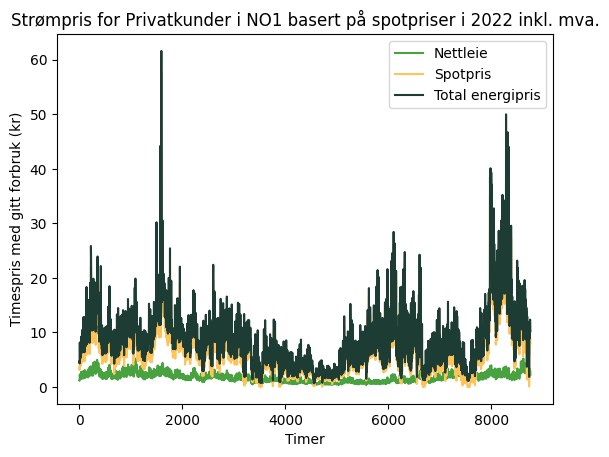

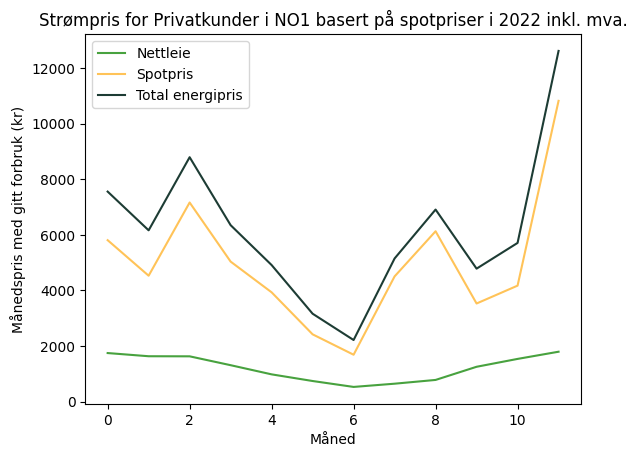

Total energikostnad dette året: 74334 kr.


In [92]:
hele_strompris(forbruksfil,prissats_fil,spotprisfil,spotprisfil_aar,sone,type_kunde,mva,skuddaar)